In [36]:
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data_dir = 'data/'
data_file = 'dataset_SCL.csv'

# use pathlib to create a path to the data file 
data_path = Path(data_dir + data_file)

In [3]:
df = pd.read_csv(data_path) 


/tmp/ipykernel_6385/3027768589.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


In [4]:
df.head()


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [5]:
df.isnull().sum().to_frame().T

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [6]:
df[df.isnull().any(axis=1)]


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


In [7]:
ratio = df.nunique() / df.shape[0]
display(ratio.to_frame().T)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,0.780752,0.010996,0.000015,0.000938,0.00044,0.920359,0.012697,0.000015,0.000924,0.000469,0.000455,0.000176,0.000029,0.000103,0.000029,0.000337,0.000015,0.000909


In [8]:
# since there is only one missing value we can drop the row 
df = df.dropna()

In [9]:
df.dtypes.to_frame().T


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,object,object,object,object,object,object,object,object,object,object,int64,int64,int64,object,object,object,object,object


In [10]:
# conver the date columns to datetime (Fecha-I	 and Fecha-O) 
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])


In [11]:
df.dtypes.to_frame().T


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,datetime64[ns],object,object,object,object,datetime64[ns],object,object,object,object,int64,int64,int64,object,object,object,object,object


In [12]:
# create two new columns for the year and month  
df['year'] = df['Fecha-I'].dt.year
df['month'] = df['Fecha-I'].dt.month


## Univariate analysis 

In [14]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,year,month
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,2017,1
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,2017,1
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,2017,1
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,2017,1
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,2017,1


I'll start looking for patterns in the data that may help to create decide the data transformation steps.


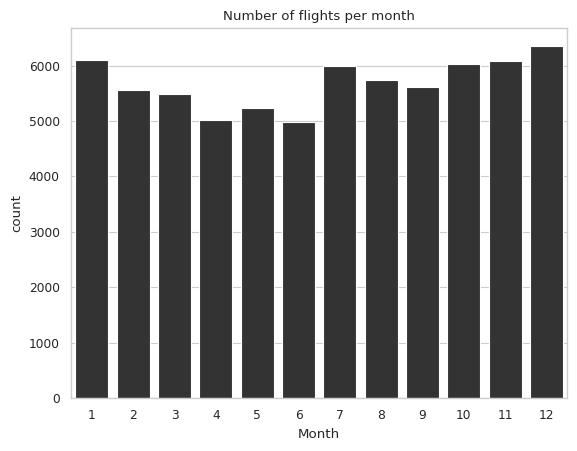

In [34]:
# Create the barplot
sns.countplot(x="month" ,data=df,
            palette=[base_color])

plt.title('Number of flights per month')
plt.xlabel('Month')
plt.show()


In [48]:
# calculate the percentage of flights per month 
df_month = df.groupby('month').size().reset_index(name='counts')
df_month['percentage'] = df_month['counts'] / df_month['counts'].sum() * 100
df_month


,month,counts,percentage
0,1,6107,8.953889
1,2,5561,8.153361
2,3,5480,8.034602
3,4,5021,7.361630
4,5,5239,7.681255
5,6,4982,7.304450
6,7,5991,8.783814
7,8,5744,8.421670
8,9,5610,8.225203
9,10,6032,8.843926


In [50]:
df['dummy'] = 1

In [52]:
# Calculate the percentage of flights for each month
flights_per_month_pct = df.groupby('month')['dummy'].apply(lambda x: x.count() / df['dummy'].count() * 100)

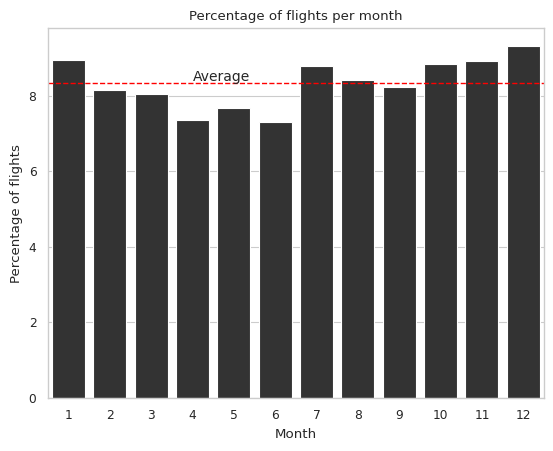

In [80]:
# add a horizontal line at 8.3% 
average_ref = 100 / 12

sns.barplot(x=flights_per_month_pct.index, y=flights_per_month_pct.values,
            palette=[base_color])

# Add a title and x and y labels
plt.title('Percentage of flights per month')
plt.xlabel('Month')
plt.ylabel('Percentage of flights')


plt.axhline(y=average_ref, color='r', linestyle='dashed', linewidth=1)
plt.text(x=3, y=8.4, s='Average', size=10)

# Show the plot
plt.show()

In [81]:
# From the above plot we can see that the number of flights is not evenly distributed over the months. 
# It seems to be some seasonal pattern, since the months with the highest number of flights are the consecutive (October, November, December and January) this could be due to the summer and vacation season in Chile 


In [88]:
# For the origin airport we can see that all the flights are from Santiago (SCL)
df.groupby('SIGLAORI').size().reset_index(name='counts')




,SIGLAORI,counts
0,Santiago,68205


In [91]:
df.groupby('SIGLADES').size().reset_index(name='counts').sort_values(by='counts', ascending=False)


,SIGLADES,counts
8,Buenos Aires,6335
0,Antofagasta,5786
28,Lima,5269
9,Calama,5146
42,Puerto Montt,4357
...,...,...
12,Cataratas Iguacu,2
41,"Pisco, Peru",1
44,Puerto Stanley,1
15,Cochabamba,1


array([[<AxesSubplot: title={'center': 'counts'}>]], dtype=object)

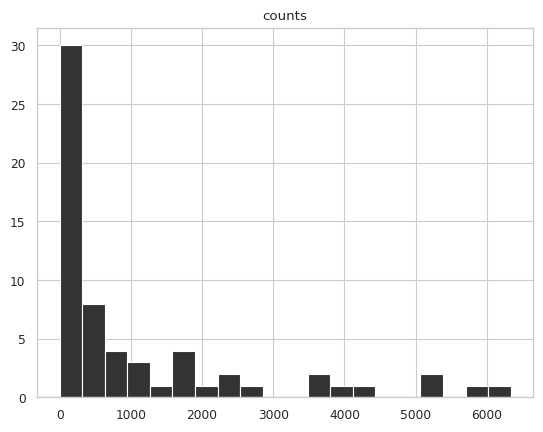

In [94]:
df.groupby('SIGLADES').size().reset_index(name='counts').hist(color=base_color,bins=20)

<AxesSubplot: >

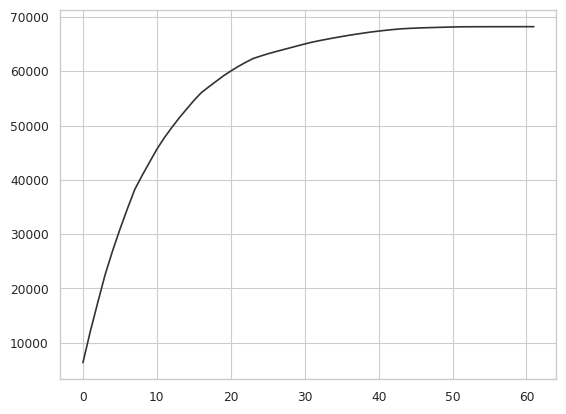

In [109]:
# from the below plot we can see that the top 10 destinations account for about 60% of the total flights

df.groupby('SIGLADES').size().reset_index(name='counts').sort_values(by='counts', ascending=False).cumsum().reset_index()['counts'].plot(color=base_color)


# In relation to the target variable it can be expected that on average the delay on the frequent flights is lower than the delay on the less frequent flights. 